# Fundamentals of Social Data Science 
## Week 3 Day 2. Lab. Text Processing 

In this lab I have generated some methods that will allow you to download posts from Reddit. It accepts a list of subreddits of arbitrary length, which are each processed independently and stored in a single `results` dictionary. The keys of the dictionary are the subreddits. Underneath each subreddit is a dictionary of sub-specific result objects, like "vectorizer" and "top terms".

Please read through the code. You will need to add your username. The code is intentionally broken so you will need to add that before running this. Other than that you should not need to make any modifications to the cell with the `RedditScraper` class. 

In the cell below is some code to run these methods. At the top are some parameters that you should set. These are typically written in ALL CAPS. You should read the code to understand what they do. 

# Exercises: 
    
0. **Explore subreddits**. The below code uses 'ukpolitics', 'unitedkingdom', and
   'uknews'. These were loosely motivated by an interest in whether uknews has become a
   reactionary subreddit with generally conservative opinions. By comparing it to the
   other two (which other work has suggested are generally quite similar), we might get
   a sense of this from the top keywords. Try some other subs related to a topic where
   you suspect there will be some interesting distinctions. Motivate the distinctions.
   If you aren't sure about the subs, query an LLM (they are typically trained on a
   _lot_ of Reddit data and will know good subs). So instead of trying for /r/men and
   /r/women, if you ask about subs for gender-based interests, it might suggest
   /r/TwoXChromosomes and /r/MensRights as interesting distinctions. 

> We are choosing to explore `r/TooAfraidToAsk`, `r/AskMen`, and `r/AskWomen`.

1. **Understand the results data structure**. The `results` object returns the top 5
   terms. How would you access more than 5 terms? Expand the results to see 10. Consider
   what way is more general and flexible. How might you change the code so that there is
   a `TOP_N = 10` which is then passed through the code so that the results dictionary
   contains ten terms in the "top_terms" DataFrame rather than hard coding it in the
   method below?

> I added a `TOP_N` global variable that I can pass into `analyze_subreddit` to vary the
> number of terms displayed.

2. **Store results**. Every time we run the code we query Reddit again. How can we store
   our data so that it is cached for another round? There are many approaches to this
   and among your group you may discover everything from 'just save the json' to
   'DataFrame and then export to feather' to some who would ambitiously use MongoDB.
   Given this is a simple exercise for now, keep this step simple as you need it to be
   while still usable enough if you want to add more data.

> I implemented a `use_cache` option in the `get_subreddit_posts` method that reads from
> and writes to JSON files in the `data/` directory if enabled.

3. **Plot keywords over time**. Expand your results to anywhere from 250 upwards (I
   would here cap at 500 max and think that the api might only return last 1000 but
   untested). Determine the top keywords using TFIDF. Then plot the frequency of these
   keywords over this time period for these results.

> I plotted daily frequencies of each term over time, using pandas and the
> `CountVectorizer` to assemble term counts per document.

4. **Table the most common URLs for stories**. Triangulate these plots with a table summarising the top news outlets for this sub in this time period. Notice the starter code to process this from the posts data that has been stored in a large `submissions` dictionary. Note, this code does not turn all the `json` into a DataFrame, but extracts only the URL column and processes that. It also uses a _regular expression_ to separate out the top level domain, which may or may not be the most robust.  
5. **Write a summary**. Solely for reflection at this point, write some intuitions that you discover with this exploration. 

## Caveats for the exercise: 
- Reddit might severely limit the number of posts you download using this scraper even with your name appropriately in the username, so be judicious with your exploration (hence exercise 2 _first_). 
- While you might not have extensive experience with Reddit, I can be confident that there are subreddits on most imaginable topics that can be found with little challenge. However, these subs will have vastly different numbers of subscribers and activity, so bear that in mind with any interpretation when tempted to generalise what is found _beyond_ Reddit (i.e. generalising from /r/republicans to Republicans in the US). 
- You may be tempted out of curiosity to expand your data collection. You will find that this will lead to a trade off if you do not further process your data. If you have 1000 rows for headlines and 3000 for words, that's a big matrix that has to be multiplied by vectors. At some point the size of the matrix will be unnecessary as well as slow. You may need to consider different parameters for `MIN_DOC_FREQ` to get a balance between a big matrix and a meaningful one. 
- These results have not been cleared for publication with CUREC, but only for use within classroom and for illustrative purposes. Please do not upload raw reddit data to your own GitHub archive nor seek to publish these results.  (Notice that I have pre-emtively edited the .gitignore to include a `data/` folder where you can store results without uploading them). Seek advice from research.fac@oii.ox.ac.uk for use for a comparable project should you wish to publish this work. If you wish to produce a blog post or other informal analysis, this should be presented in such a way that it is not misconstrued that the University has endorsed this work for publication. 

# Where we are headed with this exercise 

### Today: 
Collect reddit data, make it robust and explore TF-IDF results. 

### Week 3 Day 3. Friday: 
We use contine the use of the TF-IDF matrix and introduce cosine distance. We show how to plot it using t-SNE. This might sound abstract but the results will be fascinating as we see words plotted in coherent clusters that seem to reveal inductive patterns. 

Worksheets will be uploaded to this repo. 

### Week 4 Day 1. Monday: 
We will use two simple forms of classification, k-means and Naive Bayes Clustering. You might also be familiar with LDA or 'topic modelling'. We will not cover this as the technique deserves some care to understand its internals even if it is easy to run out of the box. But it is not far as an extension from where we end up. 

In the lab we will then compare classification results to results from the t-SNE and exploration of distance from Friday. 

### Week 4 Day 2. Wednesday: 
We will introduce the `networkx` and `community` package and show how to both construct a network from threaded comments and users of these comments. This will involve two types of graphs: DAGs and Bipartite graphs. 

In the lab you will have code that shows how to do this with the Reddit data in general. You will have to apply this to your specific case. 

### Week 4 Day 3. Friday: 
In the walkthrough we will see how to create 'embeddings' as abstractions even further than t-SNE but as a next-step up from cosine distance. In fact we will see how you can use cosine distance on embeddings which allows you to do these same steps not with words, but with entire sentences or whole paragraphs. We feature this on Friday and assume that your presentations will not need to use embeddings. 

In the afternoon you we will have the second set of group presentations: 
- Take a current event or coherent topic that could be collected from reddit data using the requests API (or more abstract packages such as `praw`, but not entire archive dumps like PushShift, only a limited subset). 
- Look at three or more subreddits who might speak to that topic. Determine which two subs are the most similar and why? Be sure to consider not only common word use. You may define similarity in creative ways so long as they can result in calculable differences without use of ML models, external APIs, or mass labelling of data. If you can download a lexicon, you are welcome to use scoring.
- Motivate this topic deductively. Where possible try to draw upon any existing literature on the topic and not simply abductively from current events. Consider DIKW: Find ways to produce transferable _knowledge_ rather than merely _information_ from _data_. 

# My Code

## Imports

In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import time

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

## Scrape data from Reddit
### Initialize scraper class

In [7]:
class RedditScraper:
    def __init__(self, user_agent):
        """
        Initialize the scraper with a user agent string.
        Example user agent: "SDS_textanalysis/1.0 (by /u/your_username)"
        """
        self.headers = {'User-Agent': user_agent}
        self.base_url = "https://api.reddit.com"
        
    def get_subreddit_posts(
        self, subreddit: str, limit: int = 100, use_cache: bool = False
    ) -> list[dict]:
        """Collect posts from a subreddit with proper pagination and rate limiting.

        Args:
            subreddit (str): The name of the subreddit to collect from.
            limit (int, optional): The limit to the number of posts fetched. Defaults to
                100.
            use_cache (bool, optional): Whether to read and write from JSON files in the
            data/ dir as a cache. Defaults to False.

        Returns:
            list[dict]: A list of structured data about posts from the subreddit, up to
                length `limit`.
        """
        posts = []
        after = None

        data_path = os.path.join("data", f"{subreddit}.json")

        # Check if cache exists
        if use_cache and os.path.exists(data_path):
            print(f"Using cache at {data_path}.")
            return json.load(open(data_path))[:limit]
        
        while len(posts) < limit:
            url = f"{self.base_url}/r/{subreddit}/new"
            params = {
                'limit': min(100, limit - len(posts)),
                'after': after
            }
            
            response = requests.get(url, headers=self.headers, params=params)
            
            if response.status_code != 200:
                print(f"Error accessing r/{subreddit}: {response.status_code}")
                break
                
            data = response.json()
            new_posts = data['data']['children']
            if not new_posts:
                break
                
            posts.extend([post['data'] for post in new_posts])
            after = data['data']['after']
            
            if not after:
                break
                
            time.sleep(2)

        # Save to cache if requested
        if use_cache:
            print(f"Saving {len(posts[:limit])} posts to {data_path}.")
            with open(data_path, "w") as f:
                json.dump(posts[:limit], f)

        return posts[:limit]

def preprocess_text(text):
    """
    Clean and normalize text.
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def analyze_vocabulary(texts, min_freq=2):
    """
    Analyze vocabulary distribution in a corpus.
    Returns word frequencies and vocabulary statistics.
    """
    # Tokenize all texts
    words = ' '.join(texts).split()
    
    # Count word frequencies
    word_freq = Counter(words)
    
    # Calculate vocabulary statistics
    total_words = len(words)
    unique_words = len(word_freq)
    
    # Create frequency distribution DataFrame
    freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'frequency'])
    freq_df['percentage'] = freq_df['frequency'] / total_words * 100
    freq_df = freq_df.sort_values('frequency', ascending=False)
    
    # Calculate cumulative coverage
    freq_df['cumulative_percentage'] = freq_df['percentage'].cumsum()
    
    stats = {
        'total_words': total_words,
        'unique_words': unique_words,
        'words_min_freq': sum(1 for freq in word_freq.values() if freq >= min_freq),
        'coverage_top_1000': freq_df.iloc[:1000]['frequency'].sum() / total_words * 100 if len(freq_df) >= 1000 else 100
    }
    
    return freq_df, stats

def analyze_subreddit(
    posts, max_terms: int = 1000, min_doc_freq: int = 2, top_n: int = 5
) -> dict:
    """Analyze a single subreddit's posts independently.

    Args:
        posts (list[dict]): A list of structured data for the subreddit's posts.
        max_terms (int, optional): The maximum number of terms to rank with the TF-IDF
            vectorizer. Defaults to 1000.
        min_doc_freq (int, optional): The minimum number of documents a term must appear
            in to be included in the TF-IDF matrix. Defaults to 2.
        top_n (int, optional): The number of top terms by aggregated TF-IDF score to
            display. Defaults to 5.

    Returns:
        dict: Some structured data summarizing the subreddit's posts and key terms.
    """
    # Use combined title and selftext
    texts = [p["text"] for p in posts]
    
    # Analyze vocabulary first
    freq_df, vocab_stats = analyze_vocabulary(texts, min_freq=min_doc_freq)
    
    # Initialize TF-IDF vectorizer for this subreddit
    stop_words = list(set(stopwords.words('english')))
    vectorizer = TfidfVectorizer(
        stop_words=stop_words,
        max_features=max_terms,
        min_df=min_doc_freq
    )
    
    # Compute TF-IDF
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Get average TF-IDF scores
    mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
    
    # Get top terms
    feature_names = vectorizer.get_feature_names_out()
    top_terms = pd.DataFrame({
        'term': feature_names,
        'score': mean_tfidf
    }).sort_values('score', ascending=False)
    
    return {
        'vocab_stats': vocab_stats,
        'freq_distribution': freq_df,
        'top_terms': top_terms.head(top_n),
        'vectorizer': vectorizer,
        'matrix_shape': tfidf_matrix.shape,
        'matrix_sparsity': 100 * (1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
    }


### Set parameters

In [8]:
# Example subreddits
subreddits = ['TooAfraidToAsk', 'AskMen', 'AskWomen']

# Analysis parameters
MAX_TERMS = 1000
MIN_DOC_FREQ = 2
LIMIT = 500
TOP_N = 10  # The number of top terms to display from the results object
USERNAME = os.getenv("REDDIT_USERNAME")

### Run scraper to collect data

In [9]:
# Initialize scraper
scraper = RedditScraper(
user_agent=f"SDS_textanalysis/1.0 (by /u/{USERNAME})"
)

# Analyze each subreddit independently
results = {}
submissions = {}

for subreddit in subreddits:
    print(f"\nAnalyzing r/{subreddit}...")

    # Collect posts
    submissions[subreddit] = scraper.get_subreddit_posts(
        subreddit, limit=LIMIT, use_cache=True
    )

    # Perform the text processing on submissions here rather than in the
    # analyze_subreddit function; this way we get the processed text data saved in
    # the submissions dict
    submissions[subreddit] = [
        {
            **post,
            "text": (
                preprocess_text(post.get('title', '')) + ' ' +
                preprocess_text(post.get('selftext', ''))
            )
        } for post in submissions[subreddit]
    ]

    # Analyze subreddit
    results[subreddit] = analyze_subreddit(
        submissions[subreddit],
        max_terms=MAX_TERMS,   # Maximum number of terms to keep
        min_doc_freq=MIN_DOC_FREQ,   # Term must appear in at least min_doc_freq documents
        top_n=TOP_N   # Number of top terms to display
    )

    # Print results for this subreddit
    print(f"\nVocabulary Statistics for r/{subreddit}:")
    print(f"Total words: {results[subreddit]['vocab_stats']['total_words']}")
    print(f"Unique words: {results[subreddit]['vocab_stats']['unique_words']}")
    print(f"Words appearing ≥{MIN_DOC_FREQ} times: {results[subreddit]['vocab_stats']['words_min_freq']}")
    print(f"Coverage by top {MAX_TERMS} words: {results[subreddit]['vocab_stats']['coverage_top_1000']:.2f}%")
    print(f"Matrix shape: {results[subreddit]['matrix_shape']}")
    print(f"Matrix sparsity: {results[subreddit]['matrix_sparsity']:.2f}%")

    print(f"\nTop {TOP_N} terms by TF-IDF score:")
    print(results[subreddit]['top_terms'][['term', 'score']].to_string())


Analyzing r/TooAfraidToAsk...
Using cache at data/TooAfraidToAsk.json.

Vocabulary Statistics for r/TooAfraidToAsk:
Total words: 52828
Unique words: 5920
Words appearing ≥2 times: 2923
Coverage by top 1000 words: 84.01%
Matrix shape: (500, 1000)
Matrix sparsity: 97.29%

Top 10 terms by TF-IDF score:
       term     score
440      im  0.044684
500    like  0.044397
648  people  0.039609
238    dont  0.031056
987   would  0.030627
479    know  0.028720
300    feel  0.026879
346     get  0.024652
461     ive  0.023110
767     sex  0.022086

Analyzing r/AskMen...
Using cache at data/AskMen.json.

Vocabulary Statistics for r/AskMen:
Total words: 53148
Unique words: 5349
Words appearing ≥2 times: 2627
Coverage by top 1000 words: 86.42%
Matrix shape: (500, 1000)
Matrix sparsity: 97.17%

Top 10 terms by TF-IDF score:
       term     score
560     men  0.047653
442      im  0.046468
507    like  0.041020
350     get  0.034013
959   whats  0.031248
986   would  0.029220
481    know  0.029061
23

In [10]:
# TODO consider removing analysis of links, given our choice of subreddits, they aren't
# very interesting...
# # Data Exploration:
# example_sub = subreddits[2]

# submissions[example_sub][0]

# url_list = [post['url'] for post in submissions[example_sub]]
# url_df = pd.DataFrame(url_list, columns=['url'])
# url_df['domain'] = url_df['url'].str.extract(r'(https?://[^/]+)')

# url_df['domain'].value_counts().head(10)

In [11]:
results[subreddits[0]].keys()

dict_keys(['vocab_stats', 'freq_distribution', 'top_terms', 'vectorizer', 'matrix_shape', 'matrix_sparsity'])

## Plot keywords over time

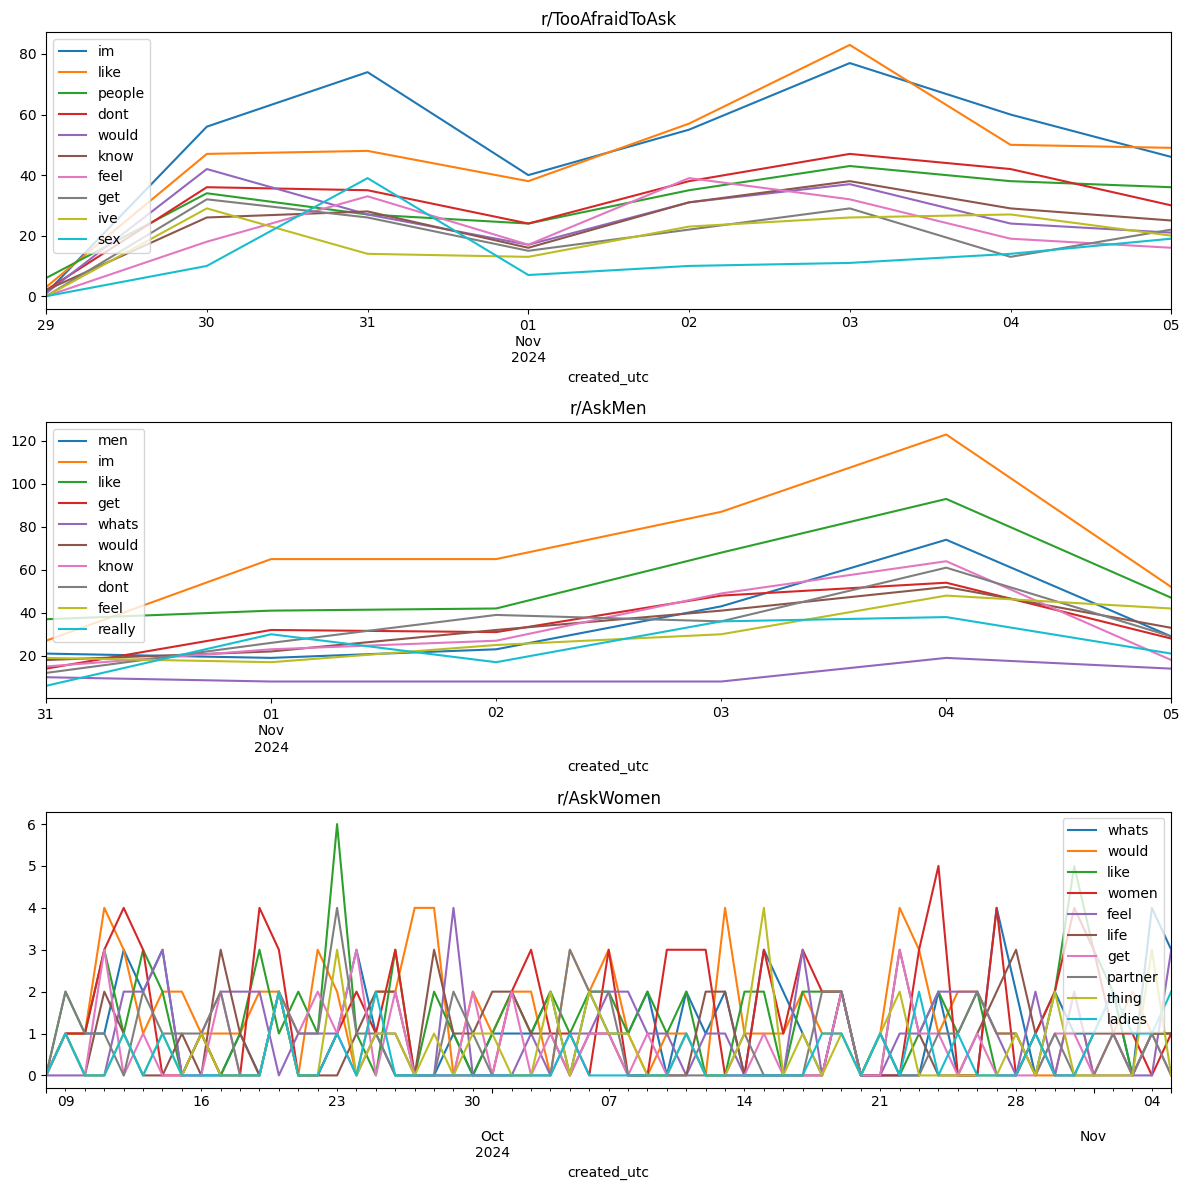

In [31]:
posts_dfs: dict[str, pd.DataFrame] = {}

# Create a plt figure with 4 rows and 1 column
fig, axs = plt.subplots(len(subreddits), 1, figsize=(12, 12))

for i, subreddit in enumerate(subreddits):
    top_terms = results[subreddit]["top_terms"]["term"].values[:TOP_N]

    v = CountVectorizer()
    X = v.fit_transform([post['text'] for post in submissions[subreddit]])

    # Create a DataFrame with the top terms and index by post created time
    df = pd.DataFrame(X.toarray(), columns=v.get_feature_names_out())
    df["created_utc"] = [post["created_utc"] for post in submissions[subreddit]]
    df["created_utc"] = pd.to_datetime(df["created_utc"], unit="s")
    df = df.set_index("created_utc")
    df = df[top_terms]

    # Resample to daily frequency
    df = df.resample("D").sum()

    # Plot the top terms in the i-th subplot
    df.plot(ax=axs[i], title=f"r/{subreddit}")

fig.tight_layout()

# AI Declaration: 

Claude Sonnet 3.5 New produced much of the reddit code. I was surprised at how similar it was to my past code (knowing it was trained on GitHub I have to wonder). Several tweaks had to be made such as removing a main() function, altering the results object, altering some NLTK packages, adding the submissions dictionary and the submissions dictionary code. I kept in the `preprocess_text()` function as is, but you are encouraged to consider alternative forms of pre-processing from the walkthrough including the use of standard tokenizers, lemmatisation, and stop-words. It also used anodyne programming subreddits which I changed and I reduced the limit to 50 which is just enough to get two queries illustrating that you can get N queries through this approach. 

The URL code was written in VS code with co-pilot. Notably the autocomplete did an excellent job of anticipating steps with minimal prompting. 